In [28]:
!pip install kagglehub tensorflow scikit-learn pandas matplotlib seaborn openpyxl



[notice] A new release of pip is available: 24.0 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [29]:
#imports
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os



In [30]:
#create Project Folders
os.makedirs("saved_models", exist_ok=True)


In [31]:
#Download Dataset
import kagglehub

# Store both download paths in a single list
path = kagglehub.dataset_download("anaselmasry/datasetbusiwithgt")

# This will print both paths inside the list brackets
print("Paths to dataset files:", path)



Paths to dataset files: C:\Users\Hp\.cache\kagglehub\datasets\anaselmasry\datasetbusiwithgt\versions\1


In [32]:
import os

base_path = os.path.join(path, "Dataset_BUSI_with_GT")

train_dir = os.path.join(base_path, "train")
test_dir = os.path.join(base_path, "test")

print(train_dir)
print(test_dir)


C:\Users\Hp\.cache\kagglehub\datasets\anaselmasry\datasetbusiwithgt\versions\1\Dataset_BUSI_with_GT\train
C:\Users\Hp\.cache\kagglehub\datasets\anaselmasry\datasetbusiwithgt\versions\1\Dataset_BUSI_with_GT\test


In [33]:
import os

for folder in [train_dir, test_dir]:
    wrong = os.path.join(folder, "maligant")
    correct = os.path.join(folder, "malignant")

    if os.path.exists(wrong):
        os.rename(wrong, correct)

print("Rename complete")


Rename complete


In [34]:
import shutil

for folder in [train_dir, test_dir]:
    normal_path = os.path.join(folder, "normal")
    if os.path.exists(normal_path):
        shutil.rmtree(normal_path)

print("Normal class removed")


Normal class removed


In [35]:
import tensorflow as tf

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.1,
    horizontal_flip=True
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224,224),
    batch_size=16,
    class_mode="binary"
)

val_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224,224),
    batch_size=16,
    class_mode="binary"
)


Found 521 images belonging to 2 classes.
Found 126 images belonging to 2 classes.


In [36]:
print("Class mapping:", train_data.class_indices)
import numpy as np
print(np.unique(train_data.classes, return_counts=True))


Class mapping: {'benign': 0, 'malignant': 1}
(array([0, 1], dtype=int32), array([353, 168]))


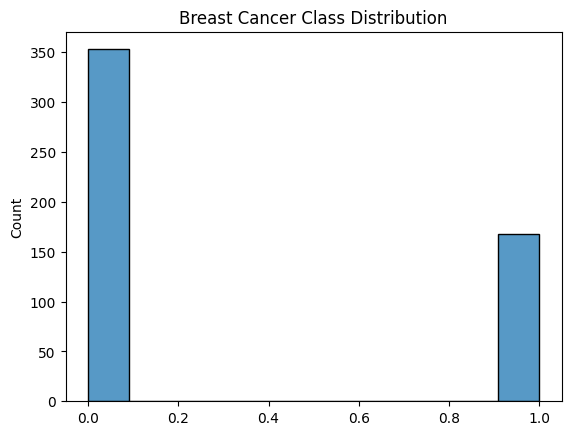

In [37]:
#Class Distribution
labels = train_data.classes
sns.histplot(labels)
plt.title("Breast Cancer Class Distribution")
plt.show()


In [38]:
base_model = tf.keras.applications.EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=(224,224,3)
)

base_model.trainable = False

x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(128, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(1, activation="sigmoid")(x)

model = tf.keras.Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_1     │ (None, 224, 224,  │          7 │ rescaling_2[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_3         │ (None, 224, 224,  │          0 │ normalization_1[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_3[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,218,788 (16.09 MB)

 Trainable params: 166,657 (651.00 KB)

 Non-trainable params: 4,052,131 (15.46 MB)

In [39]:
print("Train label distribution:")
print(np.unique(train_data.labels if hasattr(train_data,"labels") else y, return_counts=True))


Train label distribution:
(array([0, 1], dtype=int32), array([353, 168]))


In [40]:
#Train Model
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5),
    tf.keras.callbacks.ReduceLROnPlateau()
]

history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=25
)



Epoch 1/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.5950 - loss: 0.7098 - val_accuracy: 0.6667 - val_loss: 0.6697
Epoch 2/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 31s 941ms/step - accuracy: 0.6392 - loss: 0.6622 - val_accuracy: 0.6667 - val_loss: 0.6730
Epoch 3/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 30s 905ms/step - accuracy: 0.6315 - loss: 0.6771 - val_accuracy: 0.6667 - val_loss: 0.6662
Epoch 4/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 30s 905ms/step - accuracy: 0.6219 - loss: 0.6966 - val_accuracy: 0.6667 - val_loss: 0.6653
Epoch 5/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 30s 901ms/step - accuracy: 0.6526 - loss: 0.6683 - val_accuracy: 0.6667 - val_loss: 0.6685
Epoch 6/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 32s 957ms/step - accuracy: 0.6718 - loss: 0.6594 - val_accuracy: 0.6667 - val_loss: 0.6673
Epoch 7/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 31s 951ms/step - accuracy: 0.6392 - loss: 0.6582 - val_accuracy: 0.6667 - val_loss: 0.6695
Epoch 8/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 31s 931ms/step - accuracy: 0.6372 - loss: 0.6801 - val_accurac

Final Training Accuracy: 0.6545105576515198
Final Validation Accuracy: 0.6666666865348816


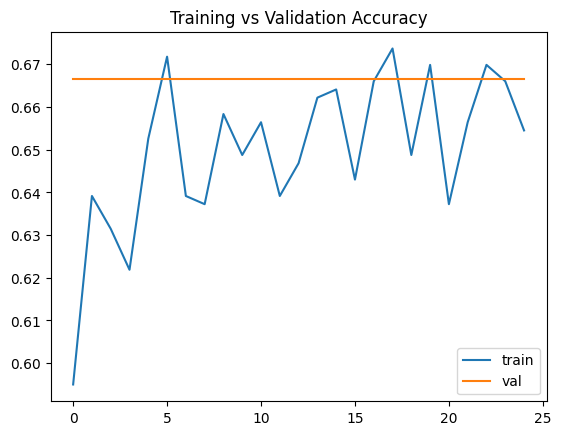

In [41]:
#Performance Metrics
print("Final Training Accuracy:", history.history["accuracy"][-1])
print("Final Validation Accuracy:", history.history["val_accuracy"][-1])


plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.legend(["train","val"])
plt.title("Training vs Validation Accuracy")
plt.show()


In [42]:
#save model
model.save("saved_models/breast_cnn_model.h5")


In [43]:
# ============================================================
# TCIA BREAST CLINICAL DATA 
# ============================================================

import pandas as pd
import numpy as np
import joblib
import os

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report

# ------------------------------------------------------------
# 1. LOAD DATASET
# ------------------------------------------------------------

df = pd.read_excel("../data/TCIA-Breast-clinical-data-public-7_16_11.xlsx")

print("Original shape:", df.shape)
display(df.head())

# ------------------------------------------------------------
# 2. DATASET STRUCTURE FIX
# ------------------------------------------------------------
# Current structure:
# rows = features
# columns = patients
# We convert to:
# rows = patients
# columns = features

# Feature names (Background, Dx, ER, PR, etc.)
feature_names = df["Unnamed: 1"].fillna(df["Breast Dx Case"])

# Patient values
patient_values = df.iloc[:, 2:]

# Set feature names as index
patient_values.index = feature_names

# Transpose → patients become rows
df_ml = patient_values.T

print("\nRestructured shape:", df_ml.shape)
display(df_ml.head())

# ------------------------------------------------------------
# 3. CLEAN DATA
# ------------------------------------------------------------

# forward fill missing values
df_ml = df_ml.ffill()

# replace remaining missing
df_ml = df_ml.fillna("Unknown")

# ------------------------------------------------------------
# 4. CREATE BINARY CANCER LABEL
# ------------------------------------------------------------

if "Dx" not in df_ml.columns:
    raise ValueError("Dx column missing")

def map_cancer_label(text):
    text = str(text).lower()

    if "benign" in text:
        return 0   # no cancer
    if "carcinoma" in text or "cancer" in text or "invasive" in text:
        return 1   # cancer

    return np.nan

df_ml["cancer_label"] = df_ml["Dx"].apply(map_cancer_label)

df_ml = df_ml.dropna(subset=["cancer_label"])

print("Cancer label distribution:")
print(df_ml["cancer_label"].value_counts())


# ------------------------------------------------------------
# 5. CONVERT MEDICAL TEXT → NUMERIC
# ------------------------------------------------------------

label_encoders = {}

for col in df_ml.columns:
    le = LabelEncoder()
    df_ml[col] = le.fit_transform(df_ml[col].astype(str))
    label_encoders[col] = le

print("Categorical encoding complete")

# ------------------------------------------------------------
# 6. CREATE FEATURES + TARGET
# ------------------------------------------------------------

X = df_ml.drop(columns=[target_column])
y = df_ml[target_column]

print("Training samples:", len(X))
print("Features:", X.shape[1])

if len(X) == 0:
    raise ValueError("No training samples")

# ------------------------------------------------------------
# 7. TRAIN MODEL
# ------------------------------------------------------------

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=10,
    random_state=42
)

rf.fit(X_train, y_train)

# ------------------------------------------------------------
# 8. EVALUATE
# ------------------------------------------------------------

pred = rf.predict(X_test)

print("\nClinical Model Accuracy:", accuracy_score(y_test, pred))
print("\nClassification Report:")
print(classification_report(y_test, pred))

# ------------------------------------------------------------
# 9. SAVE MODEL FOR BACKEND
# ------------------------------------------------------------

os.makedirs("saved_models", exist_ok=True)

joblib.dump(rf, "saved_models/clinical_model.pkl")

print("\nModel saved → saved_models/clinical_model.pkl")


Original shape: (15, 53)


c:\Users\Hp\Documents\GitHub\Breast-canser_screening\.venv\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,Breast Dx Case,Unnamed: 1,BreastDX-01-0001,BreastDX-01-0002,BreastDX-01-0003,BreastDX-01-0004,BreastDX-01-0005,BreastDX-01-0006,BreastDX-01-0007,BreastDX-01-0008,...,BreastDX-01-0065,BreastDX-01-0066,BreastDX-01-0067,BreastDX-01-0068,BreastDX-01-0069,BreastDX-01-0070,BreastDX-01-0071,BreastDX-01-0072,BreastDX-01-0073,BreastDX-01-0074
0,Background,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,40s-year-old with newly engorged left nipple,age: 50s with history of right breast DCIS and...,70s y.o.with left breast cancer (biopsy proven...,50s y. o. with history of right breast cancer ...,NaN,late 20's y.o. with bx-proven CA,50s y.o. with recent diagnosed left breast CA,history of right mastectomy\nfor cancer presen...,late 50's y.o.left nipple discharge and suspic...,NaN
1,Pathology,Dx,benign fibrosis,infiltrat lobular,Invasive ductal CA,benign fibrosis,infiltrating ductal CA,NaN,benign fibroadenoma,benign fibrosis,...,INVASIVE LOBULAR CARCINOMA. SIZE OF INVASIVE C...,NaN,NaN,INVASIVE DUCTAL CARCINOMA MODIFIED SCARFF-BLO...,INVASIVE DUCTAL CARCINOMA,"Invasive ductal carcinoma, modified Scarff-Blo...",Invasive Lobular Carcinoma,specimen: INVASIVE CARCINOMA. Lymph nodes reac...,NaN,NaN
2,NaN,Which breast,L,R,L,L,R,NaN,NaN,L,...,L,L,L,L,R,R,L,L,U,R
3,NaN,ER,NaN,pos,pos,NaN,pos (strongly),NaN,NaN,NaN,...,NaN,pos (strong),pos (strong),pos (weak),NaN,pos (strong),NaN,neg,NaN,pos (strong)
4,NaN,PR,NaN,neg (stain moderate),pos (weak),NaN,pos (weak),NaN,NaN,NaN,...,NaN,pos (strong),pos (strong),pos (weak),NaN,pos (strong),NaN,neg,NaN,pos (strong)



Restructured shape: (51, 15)


Unnamed: 1,Background,Dx,Which breast,ER,PR,HER2,E-Cadherin,Ki67,Oncotype score,Oncotype risk,Age decade,Notes,Which breast?,BIRAD,Impression
BreastDX-01-0001,NaN,benign fibrosis,L,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BreastDX-01-0002,NaN,infiltrat lobular,R,pos,neg (stain moderate),neg,neg,high prolif,NaN,NaN,40,re-bx single 1cm residual CA focus,R,6,RIGHT BREAST: There is moderate background enh...
BreastDX-01-0003,NaN,Invasive ductal CA,L,pos,pos (weak),neg,NaN,intermed prolif,NaN,NaN,50,re-bx 6/21/10 was scar tissue from RT rx,L,NaN,NaN
BreastDX-01-0004,NaN,benign fibrosis,L,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,L,NaN,NaN
BreastDX-01-0005,NaN,infiltrating ductal CA,R,pos (strongly),pos (weak),moderate by FISH,NaN,high prolif,NaN,NaN,NaN,RIGHT BREAST MASS: INFILTRATING DUCTAL CARCI...,NaN,5,RIGHT BREAST: There is moderate background enh...


c:\Users\Hp\Documents\GitHub\Breast-canser_screening\.venv\Lib\site-packages\sklearn\ensemble\_forest.py:830: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  check_classification_targets(y)


Cancer label distribution:
cancer_label
1.0    29
0.0    12
Name: count, dtype: int64
Categorical encoding complete
Training samples: 41
Features: 15


c:\Users\Hp\Documents\GitHub\Breast-canser_screening\.venv\Lib\site-packages\sklearn\tree\_classes.py:297: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  check_classification_targets(y)
c:\Users\Hp\Documents\GitHub\Breast-canser_screening\.venv\Lib\site-packages\sklearn\tree\_classes.py:297: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  check_classification_targets(y)
c:\Users\Hp\Documents\GitHub\Breast-canser_screening\.venv\Lib\site-packages\sklearn\tree\_classes.py:297: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  check_classification_targets(y)
c:\Users\Hp\Documents\GitHub\Breast-canser_screening\.venv\Lib\site-packages\sklearn\tree\_classe


Clinical Model Accuracy: 0.6666666666666666

Classification Report:
              precision    recall  f1-score   support

           8       0.67      1.00      0.80         2
           9       0.00      0.00      0.00         1
          10       1.00      1.00      1.00         1
          11       0.00      0.00      0.00         1
          13       0.50      1.00      0.67         1
          15       1.00      1.00      1.00         1
          17       1.00      0.50      0.67         2

    accuracy                           0.67         9
   macro avg       0.60      0.64      0.59         9
weighted avg       0.65      0.67      0.62         9


Model saved → saved_models/clinical_model.pkl


In [44]:
# Convert Model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

open("saved_models/model.tflite","wb").write(tflite_model)


INFO:tensorflow:Assets written to: C:\Users\Hp\AppData\Local\Temp\tmpdff60ux7\assets


INFO:tensorflow:Assets written to: C:\Users\Hp\AppData\Local\Temp\tmpdff60ux7\assets


Saved artifact at 'C:\Users\Hp\AppData\Local\Temp\tmpdff60ux7'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_251')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  1750160771216: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  1750160772560: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  1748993846416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1748994973264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1748994972496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1748993844304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1748993845840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1748994973072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1748994974224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1748994974032: TensorSpec(shape=(), dtype=tf.resource,

16683728